# Multi-Agent Collaboration and Orchestration using LangGraph for Mistral Models

## Introduction

This notebook demonstrates a sophisticated multi-agent system built with LangGraph and powered by Amazon Bedrock and Mistral. This Multi-Agent City Information System provides comprehensive information about a city, including events, weather, activities, and recommendations.

## Goals and Expected Outcomes

This notebook aims to demonstrate and achieve the following:

1. Integration and Orchestration:
   - Showcase the integration of Mistral with AWS services for building complex LLM applications.
   - Demonstrate the power of LangGraph in creating and orchestrating multi-agent systems.
   - Illustrate the integration of various data sources and APIs within a multi-agent framework.

2. Comprehensive City Information System:
   Create a multi-agent system that delivers:
   - Upcoming events information:
     * Retrieved from a local SQLite database
     * Searched online using the Tavily API when local data is unavailable
   - Current weather information and analysis using the OpenWeatherMap API
   - Suggested activities based on events and weather conditions
   - Outfit recommendations considering the weather

3. System Flexibility and Adaptability:
   - Demonstrate the system's ability to handle varying levels of available information across different cities.
   - Showcase the seamless switching between local and online data sources.

4. Analysis and Synthesis:
   - Provide a final analysis that combines event and weather information into coherent and useful recommendations for city visitors or residents.

## Benefits of Using Multi-Agents

- **Modularity**: Each agent focuses on a specific task, making the system easier to maintain and extend.
- **Flexibility**: Agents can be easily added, removed, or modified without affecting the entire system.
- **Scalability**: The system can handle complex workflows by distributing tasks among multiple agents.
- **Improved Performance**: Parallel processing of tasks by different agents can lead to faster results.
- **Specialization**: Each agent can be optimized for its specific task, improving overall system efficiency.

## Why Use LangGraph?

LangGraph is a powerful framework for building multi-agent systems:

- Provide a structured way to define and manage the flow of information between agents.
- Offer built-in support for state management and checkpointing.
- Allow for easy visualization of the agent workflow.
- Integrate well with large language models and other AI tools.
- Support conditional routing, enabling dynamic workflow adjustments based on intermediate results.

## System Components

Our multi-agent system consists of the following components:

1. **EventsDB Tool**: Queries a local SQLite database for event information.
2. **Search Tool**: Utilizes the Tavily API to search for online event information when local data is unavailable.
3. **Weather Tool**: Fetches current weather data using the OpenWeatherMap API.
4. **Analysis Node**: Synthesizes information from other agents to provide comprehensive recommendations.

## Key Technologies Used

- **Amazon Bedrock**: For accessing the Mistral large language model
- **LangGraph**: For orchestrating the multi-agent system
- **Langchain**: For building the RAG pipeline and other LLM interactions
- **SQLite**: For local event database storage
- **Tavily API**: For online event searches
- **OpenWeatherMap API**: For current weather data

By the end of this notebook, you'll have a clear understanding of how to build a sophisticated multi-agent system that can process and synthesize information from various sources, adapting to different scenarios and data availability to provide valuable insights about a city.


## Environment Setup

Before we begin, ensure you have the necessary permissions and credentials to access Amazon Bedrock and other AWS services. You'll also need to install the required Python libraries.


In [ ]:
# Install required packages
%pip install --upgrade --no-cache-dir --force-reinstall \
    boto3 \
    botocore \
    faiss-cpu \
    ipython \
    langchain \
    langchain-community \
    langgraph \
    pandas \
    pydantic \
    pyowm \
    tavily-python

## Setup and Requirements

Sign up for the following API keys as they will be used by the agents throughout this notebook:

a. **Tavily Search API** is used for performing web searches to find up-to-date information about events in various cities.
: 
   - Visit [Tavily AI](https://tavily.com/) and sign up for an account.
   - Once registered, navigate to your dashboard to find your API key.
   - Set the environment variable `TAVILY_API_KEY` with your Tavily API key.

b. **OpenWeatherMap API** provides current weather data for cities worldwide, which is used in our weather analysis.

   - Go to [OpenWeatherMap](https://openweathermap.org/) and create an account.
   - After signing up, go to your account dashboard and find your API key.
   - Set the environment variable `OPENWEATHERMAP_API_KEY` with your OpenWeatherMap API key.


Now, let's import the necessary libraries and set up our environment:

In [1]:
# Standard library imports
import json
import logging
import os
import sys
import traceback
from datetime import datetime
from typing import List, Dict

# AWS and third-party imports
import boto3
import pandas as pd
import sqlite3
from IPython.display import Image, display
from pydantic import BaseModel, Field
from tavily import TavilyClient

# LangChain imports
from langchain.docstore.document import Document
from langchain.vectorstores import FAISS
from langchain_aws import BedrockEmbeddings
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_text_splitters import RecursiveJsonSplitter

# LangGraph imports
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolInvocation
from langgraph.checkpoint.memory import MemorySaver

# Set up logging and API keys
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

os.environ["OPENWEATHERMAP_API_KEY"] = "your_openweathermap_api_key"
os.environ['TAVILY_API_KEY'] = 'your_tavily_api_key'
AWS_REGION = "us-east-1"
DEFAULT_MODEL = "mistral.mistral-large-2402-v1:0"
DEFAULT_EMBEDDINGS = "amazon.titan-embed-text-v2:0"

# Initialize Bedrock client
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name=AWS_REGION)

# Define state structure using Pydantic
class State(BaseModel):
    city: str
    messages: List[Dict] = Field(default_factory=list)
    events_result: str = ""
    search_result: str = ""
    weather_info: Dict[str, str] = Field(default_factory=dict)
    analysis_result: str = ""
    restaurant_recommendations: str = ""

print("Setup complete!")

Setup complete!


## Use Case Explanation

This system takes a city name as input and provides the following information:

1. **Events**: It searches a local database and online sources for upcoming events in the city.
2. **Weather**: It fetches current weather information for the city.
3. **Activities**: Based on the events and weather, it suggests suitable activities.
4. **Outfit Recommendations**: Considering the weather, it provides clothing suggestions.
5. **Dining Options**: It recommends highly-rated restaurants in the city.

This information is particularly useful for travelers or locals planning their activities.





## Data Preparation and Database Initialization

In this section, we'll prepare our data sources and initialize our local database. We're using a SQLite database to store local event information and the Yelp dataset for restaurant recommendations.

### Event Database Setup

Let's load our event data from a JSON file and initialize our SQLite database:


In [2]:
# Load the JSON file directly into a DataFrame
df = pd.read_json('./data/eventsDB_data.json')

# Initialize the SQLite database with the DataFrame
def initialize_database(db_path, df):
    conn = sqlite3.connect(db_path)
    df.to_sql('local_events', conn, if_exists='replace', index=False)
    conn.close()
    print(f"Database initialized with {len(df)} events.")

# Initialize the database
db_path = 'local_info.db'
initialize_database(db_path, df)

Database initialized with 54 events.


### Text Generation Function

This function serves as the core of our agents, allowing them to generate text using the Mistral model. It leverages the Amazon Bedrock Converse API, which supports text generation, streaming, and external function calling (tools). For more information, see the [Amazon Bedrock Tool Use documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/tool-use.html) and the [Amazon Bedrock Conversation Inference documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference.html#conversation-inference-call).

The function works as follows:
1. Sends a user message to the Mistral model via the Bedrock Converse API.
2. Invokes the appropriate tool and incorporates the results into the conversation.
3. Continues the conversation until a final response is generated.



In [3]:
def generate_text(bedrock_client, model_id, tool_config, input_text):
    print("\nGenerating text with model:", model_id)
    
    is_mistral_model = model_id.startswith("mistral.")
    
    messages = [{
        "role": "user",
        "content": [{"text": input_text}]
    }]

    inference_config = {
        "temperature": 0.5,
        "topP": 0.9,
        "maxTokens": 8192
    } if is_mistral_model else {}

    kwargs = {
        "modelId": model_id,
        "messages": messages,
        "inferenceConfig": inference_config
    }

    if tool_config:
        kwargs["toolConfig"] = tool_config

    tool_result = None  # Initialize tool_result

    while True:
        response = bedrock_client.converse(**kwargs)
        output_message = response['output']['message']
        messages.append(output_message)  # Add assistant's response to messages
        
        stop_reason = response.get('stopReason')

        if stop_reason == 'tool_use' and tool_config:
            tool_use = output_message['content'][0]['toolUse']
            tool_use_id = tool_use['toolUseId']
            tool_name = tool_use['name']
            tool_input = tool_use['input']

            try:
                if tool_name == 'get_upcoming_events':
                    tool_result = events_database_tool(tool_input['city'])
                    json_result = json.dumps({"events": tool_result})
                elif tool_name == 'get_city_weather':
                    tool_result = weather_tool(tool_input['city'])
                    json_result = json.dumps({"weather": tool_result})
                elif tool_name == 'search_and_summarize_events':
                    tool_result = search_tool(tool_input['city'])
                    json_result = json.dumps({"events": tool_result})
                else:
                    raise ValueError(f"Unknown tool: {tool_name}")
                
                tool_response = {
                    "toolUseId": tool_use_id,
                    "content": [{"json": json.loads(json_result)}]
                }
            except Exception as e:
                print(f"Error using tool {tool_name}: {str(e)}")
                tool_response = {
                    "toolUseId": tool_use_id,
                    "content": [{"text": f"Error using {tool_name}: {str(e)}"}],
                    "status": "error"
                }
                tool_result = None  # Set tool_result to None in case of an error

            messages.append({
                "role": "user",
                "content": [{"toolResult": tool_response}]
            })
            
            # Update kwargs with new messages
            kwargs["messages"] = messages
        else:
            break

    return output_message, tool_result


### Restaurant Data Preparation (Optional)

For restaurant recommendations using RAG, we are generating synthetic restaurant data with Mistral through Amazon Bedrock. This method enables us to create a customized dataset tailored to our specific needs. The `generate_restaurants_dataset` function constructs a prompt that defines the structure and content of the restaurant data we want to generate, including fields such as name, address, ratings, and categories. We can control the number of entries generated by passing a parameter to the function (the default is 10 entries per call). The function makes multiple calls to Mistral, generating batches of data that allow us to efficiently create larger datasets (e.g., 500 entries or more). The generated data is returned as a DataFrame, making it easy to manipulate and analyze. Let's prepare this data:


> **OPTIONAL STEP**: The dataset creation step is OPTIONAL since we've already created the dataset and made it available for this project. It can be found at ./data/restaurant_data.json 

> ⏰ Note: If you want to generate the restaurant dataset from scratch, please note that this step may take up to 5 minutes to create 100 records, assuming 10 calls with 10 entries each.

In [4]:
%%time
def generate_restaurants_dataset(num_entries=10, required_cities=["Tampa", "Philadelphia"], required_cities_percentage=60, excluded_cities=["New York", "Miami", "Seattle"]):

    # Prompt for generating the synthetic dataset
    prompt = f"""Generate a dataset of {num_entries} restaurant and bar businesses in JSON format. Each business entry should include the following fields:

    - name: The name of the restaurant or bar (string)
    - address: The street address of the business (string)
    - city: The city where the business is located (string)
    - state: The state abbreviation where the business is located (string)
    - postal_code: The postal code of the business location (string)
    - stars: The rating of the business, from 1 to 5 (float)
    - review_count: The number of reviews for the business (integer)
    - is_open: Whether the business is currently open (1) or closed (0) (integer)
    - attributes: A nested object containing various attributes of the business (object)
    - categories: A comma-separated list of categories for the business, limited to restaurant and bar-related categories (string)

    Ensure that the data is diverse, covering various types of restaurants and bars, cuisines, locations, and ratings. 
    The generated dataset should be limited to restaurant and bar-related businesses only. 

    Important location requirements:
    1. At least {required_cities_percentage}% of the entries must be located in the following cities: {', '.join(required_cities)}.
    2. Do not generate any entries for the following cities: {', '.join(excluded_cities)}.
    3. The remaining entries can be for any other cities in the United States.

    Output the result as a valid JSON array without any additional text or explanation."""

    raw_output, _ = generate_text(bedrock_client, DEFAULT_MODEL, None, prompt)
    json_string = raw_output['content'][0]['text']
    #print(json_string)
    
    # Parse the generated JSON
    generated_data = json.loads(json_string)
    
    # Create a DataFrame 
    df = pd.DataFrame(generated_data)
    return df
    

# Initialize an empty DataFrame to store all records
all_restaurants_records_df = pd.DataFrame()

total_calls = 20
entries_per_call = 5

# Loop to generate data in batches
for i in range(total_calls):
    print(f"\n\nBatch {i+1} of {total_calls} invoked...")
    
    restaurant_df = generate_restaurants_dataset(num_entries=entries_per_call)
    
    if restaurant_df is not None:
        all_restaurants_records_df = pd.concat([all_restaurants_records_df, restaurant_df], ignore_index=True)
    else:
        print(f"Failed to prepare batch {i+1}. Exiting.")
        exit(1)

# Save the combined DataFrame to a JSON file
output_file = "./data/restaurant_data.json"
all_restaurants_records_df.to_json(output_file, orient="records", indent=2)

print(f"\nAll {len(all_restaurants_records_df)} records saved to {output_file}\n\n")
all_restaurants_records_df



Batch 1 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 2 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 3 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 4 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 5 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 6 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 7 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 8 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 9 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 10 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 11 of 20 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 12 of 20 invoked...

G

,name,address,city,state,postal_code,stars,review_count,is_open,attributes,categories
0,Tampa Bay Brewing Company,1600 E 8th Ave,Tampa,FL,33605,4.5,1250,1,"{'has_tv': True, 'outdoor_seating': True, 'wif...","brewery,bar,restaurant"
1,Philadelphia Distilling,25 E Allen St,Philadelphia,PA,19123,4.0,850,1,"{'happy_hour': True, 'wheelchair_accessible': ...","distillery,bar"
2,The Columbia Restaurant,2117 E 7th Ave,Tampa,FL,33605,4.5,4500,1,"{'reservations': True, 'outdoor_seating': True...","Spanish,Cuban,restaurant"
3,Monk's Cafe,264 S 16th St,Philadelphia,PA,19102,4.0,2250,1,"{'happy_hour': True, 'late_night': True, 'wifi...","bar,gastropub"
4,Boulder Cafe,1001 Walnut St,Boulder,CO,80302,4.5,1500,1,"{'vegetarian_options': True, 'vegan_options': ...","cafe,restaurant"
...,...,...,...,...,...,...,...,...,...,...
95,Tampa Bay Brewing Company,1600 E 8th Ave,Tampa,FL,33605,4.5,450,1,"{'has_tv': True, 'outdoor_seating': True, 'wif...","brewery,bar,restaurant"
96,Philadelphia Distilling,25 E Allen St,Philadelphia,PA,19123,4.0,210,1,"{'happy_hour': True, 'wheelchair_accessible': ...","distillery,bar"
97,The Columbia Restaurant,2117 E 7th Ave,Tampa,FL,33605,4.5,675,1,"{'reservations': True, 'group_friendly': True,...","spanish,cuban,restaurant"
98,Monk's Cafe,264 S 16th St,Philadelphia,PA,19102,4.0,340,1,"{'dog_friendly': True, 'accepts_credit_cards':...","belgian,bar,restaurant"


## Restaurant Vector Database Creation for RAG

To enable efficient retrieval of restaurant information, we'll create a vector database using FAISS. This forms the basis of our RAG system for restaurant recommendations.


In [5]:
def create_restaurant_vector_store(df):
    # Convert DataFrame to list of dictionaries
    print("Converting DataFrame to list of dictionaries...")
    data = df.to_dict('records')

    # Use RecursiveJsonSplitter to split documents
    print("Splitting documents...")
    json_splitter = RecursiveJsonSplitter(max_chunk_size=1000)

    split_texts = []
    metadata_list = []  # List to store metadata for each document
    for item in data:
        # Split the document into chunks
        split_texts.extend(json_splitter.split_text(json_data=item, convert_lists=True))
        
        # Directly extract metadata from the dictionary. To be used by similarity_search with filter_criteria
        metadata = {
            "city": item.get('city', ''),
            "stars": item.get('stars', 0),
            "name": item.get('name', ''),
        }
        metadata_list.append(metadata)
    
    # Create documents from split texts and attach corresponding metadata
    split_documents = [Document(page_content=text, metadata=metadata) for text, metadata in zip(split_texts, metadata_list)]

    # Initialize Bedrock Embeddings
    print("Initializing embeddings...")
    bedrock_embeddings = BedrockEmbeddings(
        region_name=AWS_REGION,
        model_id=DEFAULT_EMBEDDINGS
    )

    # Create vector store
    print("Creating vector store...")
    vectorstore = FAISS.from_documents(split_documents, bedrock_embeddings)
    num_documents = len(vectorstore.index_to_docstore_id)
    
    return vectorstore, num_documents

# Example DataFrame load
df = pd.read_json('./data/restaurant_data.json')
# Remove duplicates based on the 'name' column, keeping the first occurrence
df_cleaned = df.drop_duplicates(subset=['name'], keep='first')

restaurant_vectorstore, num_documents = create_restaurant_vector_store(df_cleaned)
print(f"Restaurant Vector Store created successfully. \nNumber of documents indexed: {num_documents}")

Converting DataFrame to list of dictionaries...
Splitting documents...
Initializing embeddings...
Creating vector store...
Restaurant Vector Store created successfully. 
Number of documents indexed: 42


### Restaurant Recommendation Function

This function uses the RAG system to provide restaurant recommendations. Used by the **Restaurant Recommendation Agent**(`query_restaurants_agent` function):


In [6]:
def query_restaurants_RAG(city, vectorstore):
    query = f"Find restaurants with 4 stars or higher ratings in {city} and describe their key features"
    print(f"\nPerforming query: {query}")

    # Define the filter based on city and star rating
    filter_criteria = {
        "stars": {"$gte": 4},  # Filter for ratings >= 4 stars
        "city": city   # Filter for the specific city (case-insensitive)
    }

    # Perform similarity search with filter
    relevant_docs = vectorstore.similarity_search(query, k=5, filter=filter_criteria)

    # Display the relevant documents
    if relevant_docs:
        print(f"\nTop {len(relevant_docs)} relevant documents for high-rated restaurants in {city}:")
        for i, doc in enumerate(relevant_docs, 1):
            print(f"\nDocument {i}:")
            print(doc.page_content)
        context = "\n\n".join([doc.page_content for doc in relevant_docs])
    else:
        print(f"No high-rated restaurants found in the vector DB for {city}.")
        context = ""

    # Generate the prompt for Bedrock
    prompt = f"""Task: Provide information about highly-rated restaurants (4 stars and above) in {city}.

    Instructions:
    1. If the following context contains information about restaurants in {city}, describe the key features that contribute to their high ratings. Consider aspects such as cuisine type, ambiance, service, price range, and any standout characteristics.
    2. Only use the information provided in the context. If certain information is not available, state that it's not mentioned.
    3. If no information is provided in the context, respond with: "I'm sorry, but I couldn't find any information about highly-rated restaurants in {city}."
    4. Do not generate or invent any information about restaurants if none is provided in the context.

    Context:
    {context}

    Please provide your response based on these instructions:"""

    # Generate text using the Bedrock model (or your chosen LLM)
    output_message, _ = generate_text(bedrock_client, DEFAULT_MODEL, None, prompt)

    # Extract the response content from the model's output
    response_content = output_message.get('content', [{}])[0].get('text', f"I'm sorry, but I couldn't find any information about highly-rated restaurants in {city}.")
    
    print("\nGenerated response:")
    print(response_content)

    return response_content


### Testing the Restaurant RAG System

While the restaurant dataset may contain more than 5 records for a given city, we set the k value in the similarity search to 5. This limits the number of records returned to a maximum of 5, ensuring the response is concise and focused on the top 5 most relevant records.

In [7]:
city="Tampa"
df_cleaned_count = df_cleaned[df_cleaned['city'] == city].shape[0]
print(f"Number of records with {city} as the city in df_cleaned: {df_cleaned_count}")
query_restaurants_RAG(city, restaurant_vectorstore)

Number of records with Tampa as the city in df_cleaned: 10

Performing query: Find restaurants with 4 stars or higher ratings in Tampa and describe their key features

Top 5 relevant documents for high-rated restaurants in Tampa:

Document 1:
{"name": "Tampa Bay Seafood House", "address": "123 Harbor Drive", "city": "Tampa", "state": "FL", "postal_code": 33602, "stars": 4.5, "review_count": 350, "is_open": 1, "attributes": {"has_tv": true, "outdoor_seating": true, "wifi": false}, "categories": "Seafood, Restaurant, Bar"}

Document 2:
{"name": "Datz", "address": "2616 S MacDill Ave", "city": "Tampa", "state": "FL", "postal_code": 33629, "stars": 4.5, "review_count": 7082, "is_open": 1, "attributes": {"accepts_credit_cards": true, "good_for_kids": true, "alcohol": "full_bar"}, "categories": "American (New), Breakfast & Brunch, Gastropubs"}

Document 3:
{"name": "The Columbia Restaurant", "address": "2117 E 7th Ave", "city": "Tampa", "state": "FL", "postal_code": 33605, "stars": 4.5, "rev

"Based on the provided context, here are the key features of the highly-rated restaurants in Tampa:\n\n1. Tampa Bay Seafood House:\n   - Cuisine Type: Seafood, Restaurant, Bar\n   - Standout Features: Outdoor seating and TV available\n   - Price Range: Not mentioned\n   - Ambiance: Not explicitly mentioned, but the presence of a TV and outdoor seating suggests a casual, relaxed atmosphere\n   - Service: Not mentioned\n\n2. Datz:\n   - Cuisine Type: American (New), Breakfast & Brunch, Gastropubs\n   - Standout Features: Accepts credit cards, good for kids, and has a full bar\n   - Price Range: Not mentioned\n   - Ambiance: Not explicitly mentioned, but the fact that it's good for kids and has a full bar suggests a family-friendly yet lively atmosphere\n   - Service: Not mentioned\n\n3. The Columbia Restaurant:\n   - Cuisine Type: Spanish, Cuban, Restaurant\n   - Standout Features: Reservations, outdoor seating, and valet parking available\n   - Price Range: Not mentioned\n   - Ambiance:

### Local Database Query Tool

This tool queries the local SQLite database for event information. Used by the **Event Database Agent**(`events_database_agent` function):


In [8]:
def events_database_tool(city: str) -> str:
    conn = sqlite3.connect(db_path)
    query = """
        SELECT event_name, event_date, description 
        FROM local_events 
        WHERE city = ?
        ORDER BY event_date
        LIMIT 3
    """
    df = pd.read_sql_query(query, conn, params=(city,))
    conn.close()
    print(df)
    if not df.empty:
        events = df.apply(lambda row: f"{row['event_name']} on {row['event_date']}: {row['description']}", axis=1).tolist()
        return "\n".join(events)
    else:
        return f"No upcoming events found for {city}."


### Weather Tool

This function fetches current weather data for the specified city by calling the . It's used by the **Weather Agent** (`weather_agent()` function):

In [9]:
def weather_tool(city: str) -> str:
    weather = OpenWeatherMapAPIWrapper()
    tool_result = weather.run("Tampa")
    return tool_result

### Online Search Tool

This tool performs an online search for events using the Tavily API. Used by the **Search Agent**(`search_agent` function):


In [10]:
def search_tool(city: str) -> str:
    client = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])
    query = f"What are the upcoming events in {city}?"
    response = client.search(query, search_depth="advanced")
    results_content = "\n\n".join([result['content'] for result in response['results']])
    return results_content


## Multi-agent System Definitions

Our multi-agent system is composed of several specialized nodes, each responsible for a specific task. These nodes are then organized into a workflow using LangGraph. Here's an overview of the key components:

### Agent Functions

1. **Events Database Agent (events_database_agent)**: Queries the local database for upcoming events in a specified city.
2. **Online Search Agent(search_agent)**: Performs an online search for events when local data is unavailable.
3. **Weather Agent(weather_agent)**: Fetches current weather information for the specified city.
4. **Restaurants Recommendation Agent(query_restaurants_agent)**: This agent uses our RAG system to provide restaurant recommendations.
5. **Analysis Agent(analysis_agent)**: Synthesizes event and weather information to provide recommendations.


### 1. Event Database Agent

This agent retrieves event information from our local database:


In [11]:
def events_database_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("events_database_agent function called")
    print("*" * 50)
    tool_config = {
        "tools": [
            {
                "toolSpec": {
                    "name": "get_upcoming_events",
                    "description": "Get upcoming events for a specific city from the local database",
                    "inputSchema": {
                        "json": {
                            "type": "object",
                            "properties": {
                                "city": {
                                    "type": "string",
                                    "description": "The name of the city to look up events for"
                                }
                            },
                            "required": ["city"]
                        }
                    }
                }
            }
        ]
    }
    
    input_text = f"Get upcoming events for {state.city} from the local database"
    output_message, tool_result = generate_text(bedrock_client, DEFAULT_MODEL, tool_config, input_text)
    
    if tool_result:
        state.events_result = tool_result
    else:
        state.events_result = "No event information available in the local database."
    
    print(f"Events set to: {state.events_result}")
    return state



### 2. Search Agent

When local event information is not available in the database, this agent performs an online search:


In [12]:
def search_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("search_agent function called")
    print("*" * 50)
    tool_config = {
        "tools": [
            {
                "toolSpec": {
                    "name": "search_and_summarize_events",
                    "description": "Search for and summarize upcoming events for a specific city",
                    "inputSchema": {
                        "json": {
                            "type": "object",
                            "properties": {
                                "city": {
                                    "type": "string",
                                    "description": "The name of the city to look up events for"
                                }
                            },
                            "required": ["city"]
                        }
                    }
                }
            }
        ]
    }
    
    input_text = f"Search for and summarize upcoming events in {state.city}"
    output_message, tool_result = generate_text(bedrock_client, DEFAULT_MODEL, tool_config, input_text)
    
    if tool_result:
        state.search_result = tool_result
    else:
        state.search_result = "No event information available from online search."
    
    print(f"Search result set to: {state.search_result[:500]}...")  # Print first 500 characters
    return state


### 3. Weather Agent

This agent fetches current weather information for the specified city:


In [13]:
def weather_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("weather_agent function called")
    print("*" * 50)
    tool_config = {
        "tools": [
            {
                "toolSpec": {
                    "name": "get_city_weather",
                    "description": "Get current weather information for a specific city",
                    "inputSchema": {
                        "json": {
                            "type": "object",
                            "properties": {
                                "city": {
                                    "type": "string",
                                    "description": "The name of the city to look up weather for"
                                }
                            },
                            "required": ["city"]
                        }
                    }
                }
            }
        ]
    }
    
    input_text = f"Get current weather for {state.city}"
    output_message, tool_result = generate_text(bedrock_client, DEFAULT_MODEL, tool_config, input_text)
    
    if tool_result:
        state.weather_info = {"city": state.city, "weather": tool_result}
    else:
        state.weather_info = {"city": state.city, "weather": "Weather information not available."}
    
    print(f"Weather info set to: {state.weather_info}")
    return state


### 4. Restaurant Recommendation Agent

This agent uses our RAG system to provide restaurant recommendations:


In [14]:
def query_restaurants_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("query_restaurants_agent function called")
    print("*" * 50)
    state.restaurant_recommendations = query_restaurants_RAG(state.city, restaurant_vectorstore)
    print(f"Restaurant recommendations set for {state.city}")
    return state


### 5. Analysis Agent

This agent synthesizes all the gathered information to provide a comprehensive analysis:


In [15]:
def analysis_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("analysis_agent function called")
    print("*" * 50)
    input_text = f"""Analyze the following information about {state.city}:

Events from local database: {state.events_result}
Events from online search: {state.search_result}
Weather: {state.weather_info['weather']}
Restaurant Recommendations: {state.restaurant_recommendations}

Please provide:
1. A brief weather analysis
2. Suggested activities based on the weather and events (from both local and online sources)
3. Outfit recommendations considering the weather
4. A summary of recommended restaurants and dining options"""

    output_message, _ = generate_text(bedrock_client, DEFAULT_MODEL, None, input_text)

    if 'content' in output_message and len(output_message['content']) > 0:
        state.analysis_result = output_message['content'][0]['text']
    else:
        state.analysis_result = "Unable to generate analysis."

    state.messages.append({"role": "assistant", "content": [{"text": state.analysis_result}]})
    
    print(f"Analysis result: {state.analysis_result[:500]}...")  # Print first 500 characters
    return state

## LangGraph Workflow Construction

Now that we have defined our agents, let's construct the LangGraph workflow that will orchestrate their interactions. The `build_graph` function creates the workflow structure:

1. Adds nodes for each agent (eventsDB, search, weather, restaurant recommendations, and analysis).
2. Sets the entry point to the events_database_agent.
3. Adds a conditional edge from events_database_agent to either search_agent or weather_agent.
4. Connects the remaining nodes in sequence.
5. Builds the graph and compiles the workflow.
6. Visualize the graph.



In [16]:
# Define the graph
def build_graph():
    workflow = StateGraph(State)

    workflow.add_node("Events Database Agent", events_database_agent)
    workflow.add_node("Online Search Agent", search_agent)
    workflow.add_node("Weather Agent", weather_agent)
    workflow.add_node("Restaurants Recommendation Agent", query_restaurants_agent)
    workflow.add_node("Analysis Agent", analysis_agent)

    workflow.set_entry_point("Events Database Agent")

    # Add conditional edge
    def route_events(state):
        print(f"Routing events. Current state: {state}")
        print(f"Events content: '{state.events_result}'")
        if f"No upcoming events found for {state.city}" in state.events_result:
            print("No events found in local DB. Routing to Online Search Agent.")
            return "Online Search Agent"
        else:
            print("Events found in local DB. Routing to Weather Agent.")
            return "Weather Agent"

    workflow.add_conditional_edges(
        "Events Database Agent",
        route_events,
        {
            "Online Search Agent": "Online Search Agent",
            "Weather Agent": "Weather Agent"
        }
    )

    workflow.add_edge("Online Search Agent", "Weather Agent")
    workflow.add_edge("Weather Agent", "Restaurants Recommendation Agent")
    workflow.add_edge("Restaurants Recommendation Agent", "Analysis Agent")
    workflow.add_edge("Analysis Agent", END)
    
    # Initialize memory to persist state between graph runs
    checkpointer = MemorySaver()

    # Compile the workflow
    app = workflow.compile(checkpointer=checkpointer)
    print("Workflow compiled successfully")
        
    # Visualize the graph
    display(
        Image(
            app.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API
            )
        )
    )

    #return app and checkpointer
    return app, checkpointer

print("Graph construction function defined.")

Graph construction function defined.


## Main Execution

Finally, let's define our main execution function that will run the entire workflow. The used function orchestrates the entire process:

1. Initializes the state with the specified city.
2. Streams the events through the workflow.
3. Retrieves and displays the final analysis and recommendations.


In [17]:
# Main execution
def main(city: str):
    try:
        print(f"Starting main execution for city: {city}")
        app, checkpointer = build_graph()
        print("Graph built successfully")
                
        initial_state = State(
            city=city,
            messages=[{"role": "user", "content": [{"text": f"What's happening in {city} and what should I wear?"}]}],
            events_result="",
            weather_info={},
            analysis_result="",
            search_result="",
            restaurant_recommendations=""
        )

        # Configuration for the stream and checkpointer
        config = {
            "recursion_limit": 150,
            "configurable": {
                "thread_id": "42"  # Using string as thread_id
            }
        }

        print("Starting to stream events")
        # Stream the events with the required configurable key
        events = app.stream(
            initial_state,
            config=config
        )

        for output in events:
            if "__end__" not in output:
                print(f"\nIntermediate output: {output}")

        # Access the final state from the checkpointer
        final_state_dict = checkpointer.get(config=config)

        # Print the final response from the assistant
        if 'channel_values' in final_state_dict and 'messages' in final_state_dict['channel_values']:
            messages = final_state_dict['channel_values']['messages']
            if messages and isinstance(messages, list):
                final_message = messages[-1]
                if final_message.get("role") == "assistant":
                    print("\nFinal response from the assistant:")
                    print(json.dumps(final_message["content"], indent=2))
                else:
                    print("\nNo final response from the assistant found in the messages.")
            else:
                print("\nNo valid messages found in the final state.")
        else:
            print("\nNo messages found in the final state.")

        # Print the full final state from checkpointer
        print("\nFinal state from checkpointer:")
        print(json.dumps(final_state_dict, indent=2))
        
    except Exception as e:
        print(f"An error occurred in main execution: {str(e)}")
        print(traceback.format_exc())

print("Main execution function defined.")


Main execution function defined.


## Results and Analysis

Let's run our multi-agent system for three different cities: Tampa, Philadelphia, and New York. Each case demonstrates different aspects of our system's functionality.

### Example 1: Tampa, Florida

Starting script execution for city: Tampa
Starting main execution for city: Tampa
Workflow compiled successfully


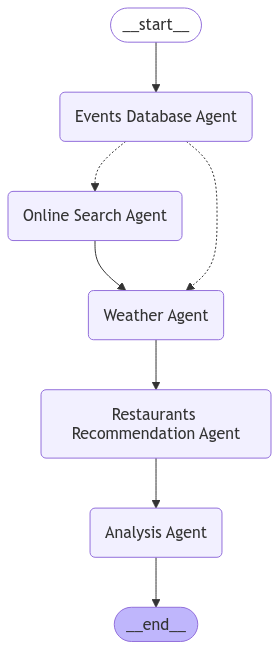

Graph built successfully
Starting to stream events

**************************************************
events_database_agent function called
**************************************************

Generating text with model: mistral.mistral-large-2402-v1:0
Empty DataFrame
Columns: [event_name, event_date, description]
Index: []
Events set to: No upcoming events found for Tampa.
Routing events. Current state: city='Tampa' messages=[{'role': 'user', 'content': [{'text': "What's happening in Tampa and what should I wear?"}]}] events_result='No upcoming events found for Tampa.' search_result='' weather_info={} analysis_result='' restaurant_recommendations=''
Events content: 'No upcoming events found for Tampa.'
No events found in local DB. Routing to Online Search Agent.

Intermediate output: {'Events Database Agent': {'city': 'Tampa', 'messages': [{'role': 'user', 'content': [{'text': "What's happening in Tampa and what should I wear?"}]}], 'events_result': 'No upcoming events found for Tampa

In [18]:
if __name__ == "__main__":
    city = "Tampa"
    print(f"Starting script execution for city: {city}")
    main(city)

### Example 2: Philadelphia, Pennsylvania


Starting script execution for city: Philadelphia
Starting main execution for city: Philadelphia
Workflow compiled successfully


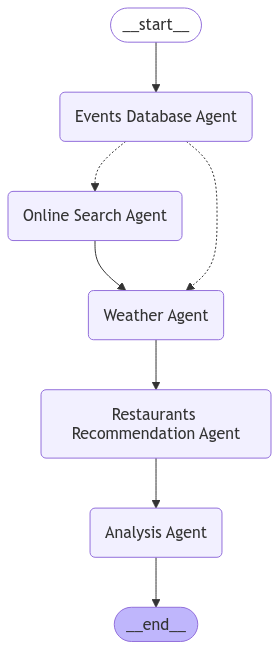

Graph built successfully
Starting to stream events

**************************************************
events_database_agent function called
**************************************************

Generating text with model: mistral.mistral-large-2402-v1:0
                   event_name  event_date  \
0    Philadelphia Flower Show  2024-03-02   
1        Wawa Welcome America  2024-06-28   
2  Philadelphia Film Festival  2024-10-17   

                                         description  
0  The world's largest indoor flower show, featur...  
1  A week-long festival celebrating Independence ...  
2  An annual film festival showcasing independent...  
Events set to: Philadelphia Flower Show on 2024-03-02: The world's largest indoor flower show, featuring elaborate garden displays.
Wawa Welcome America on 2024-06-28: A week-long festival celebrating Independence Day with concerts, fireworks, and historical reenactments.
Philadelphia Film Festival on 2024-10-17: An annual film festival showcas

In [19]:
if __name__ == "__main__":
    city = "Philadelphia"
    print(f"Starting script execution for city: {city}")
    main(city)

### Example 3: New York


Starting script execution for city: New York
Starting main execution for city: New York
Workflow compiled successfully


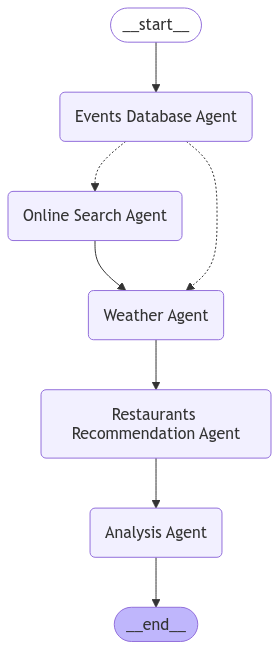

Graph built successfully
Starting to stream events

**************************************************
events_database_agent function called
**************************************************

Generating text with model: mistral.mistral-large-2402-v1:0
                       event_name  event_date  \
0           Tribeca Film Festival  2024-06-07   
1           New York Fashion Week  2024-09-05   
2  Macy's Thanksgiving Day Parade  2024-11-28   

                                         description  
0     An annual film festival in Tribeca, Manhattan.  
1            A semi-annual series of fashion events.  
2  An annual parade presented by Macy's on Thanks...  
Events set to: Tribeca Film Festival on 2024-06-07: An annual film festival in Tribeca, Manhattan.
New York Fashion Week on 2024-09-05: A semi-annual series of fashion events.
Macy's Thanksgiving Day Parade on 2024-11-28: An annual parade presented by Macy's on Thanksgiving Day.
Routing events. Current state: city='New York' mes

In [20]:
if __name__ == "__main__":
    city = "New York"
    print(f"Starting script execution for city: {city}")
    main(city)

### Analysis of Results

1. **Tampa, Florida**:
   - Events: Not found in the local database, triggering the search tool.
   - Weather: Retrieved from OpenWeatherMap API.
   - Restaurants: Recommendations provided through the RAG system.

2. **Philadelphia, Pennsylvania**:
   - Events: Found in the local database.
   - Weather: Retrieved from OpenWeatherMap API.
   - Restaurants: Recommendations provided through the RAG system.

3. **New York, New York**:
   - Events: Found in the local database.
   - Weather: Retrieved from OpenWeatherMap API.
   - Restaurants: No recommendations available in the RAG system.

#### Similarities:
- All three cases utilized the weather tool to fetch current weather information.
- The analysis node provided recommendations based on available data for each city.

#### Differences:
- Tampa required the use of the search tool for event information, while Philadelphia and New York used the local database.
- Philadelphia had both local event data and restaurant recommendations, providing the most comprehensive results.
- New York had local event data but lacked restaurant recommendations, showcasing the system's ability to work with partial information.

#### Key Observations:
1. The system adapts to available data sources, seamlessly switching between local and online searches for event information.
2. Weather information is consistently provided, forming a core part of the recommendations.
3. The RAG system for restaurant recommendations enhances the output when data is available but doesn't hinder the overall functionality when it's not.
4. The analysis node demonstrates flexibility in synthesizing varying levels of information to provide useful recommendations.

This multi-city comparison highlights the robustness and adaptability of our multi-agent system, showcasing its ability to provide valuable insights even when faced with varying levels of available information across different cities.



## Conclusion

This notebook demonstrates the power of multi-agent systems built with LangGraph and powered by Mistral on AWS Bedrock. By combining various data sources and agents, we've created a comprehensive city information system that can provide valuable insights for users.

Our system successfully gathered and analyzed information about events, weather, activities, and dining options for the specified cities. This showcases the potential of using LangGraph to create complex, multi-step workflows that can process and synthesize information from various sources.

